# Aprenentatge supervisat (Classificació)

## Nivell 1
### Exercici 1 i 2
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif as MI
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
import time
import datetime



In [2]:
## function to mesure Execution Time
def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
    
    x= datetime.time(hour=h, minute=m, second=s)   
    return (x)

In [3]:

df = pd.read_csv('DelayedFlights.csv')


In [4]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


First steps 
- analyze the dataset:
- Remove useless columns and rows
- find relationsship between data
- create new colum with the target
 - Assing 1 if ArrDelay is greater than 0 otherwise 0
    


In [5]:
## we can start dropping unnamed: 0 because lack of information
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
df['Delayed']= np.where(df['ArrDelay']>0,1,0)

In [7]:
df[['Delayed','ArrDelay']]

,Delayed,ArrDelay
0,0,-14.0
1,1,2.0
2,1,14.0
3,1,34.0
4,1,11.0
...,...,...
1936753,1,25.0
1936754,1,75.0
1936755,1,99.0
1936756,1,9.0


In [8]:
## check the relationship between diverted and  the target
df_check =df[['Diverted','ArrDelay']]
df_check[df_check['Diverted']==1]

,Diverted,ArrDelay
1280,1,NaN
1372,1,NaN
1776,1,NaN
1831,1,NaN
2244,1,NaN
...,...,...
1934369,1,NaN
1934921,1,NaN
1935596,1,NaN
1935716,1,NaN


When the value of diverted is 1  the value of arrDelay is null. that makes sense because diverted =1 means that the Flight does not follow the path scheduled.
we can remove all the rows with diverted =1 

In [9]:
df.drop(df[df.Diverted==1].index,inplace=True)

In [10]:
df.loc[df.Cancelled==1,['ArrDelay','Delayed']]

,ArrDelay,Delayed
1542406,NaN,0
1546593,NaN,0
1547161,NaN,0
1547178,NaN,0
1548271,NaN,0
...,...,...
1934590,NaN,0
1935491,NaN,0
1935651,NaN,0
1935876,NaN,0


we can see that all the flights that  cancelled is equal 1  there are not values for ArrDelay  therefore the value of Delayed will be 0 . Said that, there is no reason to use all the row that the flight was cancelled

In [11]:
df.drop(df[df.Cancelled==1].index,inplace=True)

we can remove the cancellation code column as well

In [12]:
df.drop('CancellationCode',axis=1,inplace=True)

In [13]:
d1 = df[['UniqueCarrier','Delayed']]

In [14]:
grouped =d1.groupby(['UniqueCarrier'])['Delayed'].mean().rename('Percentage').reset_index()

In [15]:
grouped['Percentage']=grouped['Percentage']*100

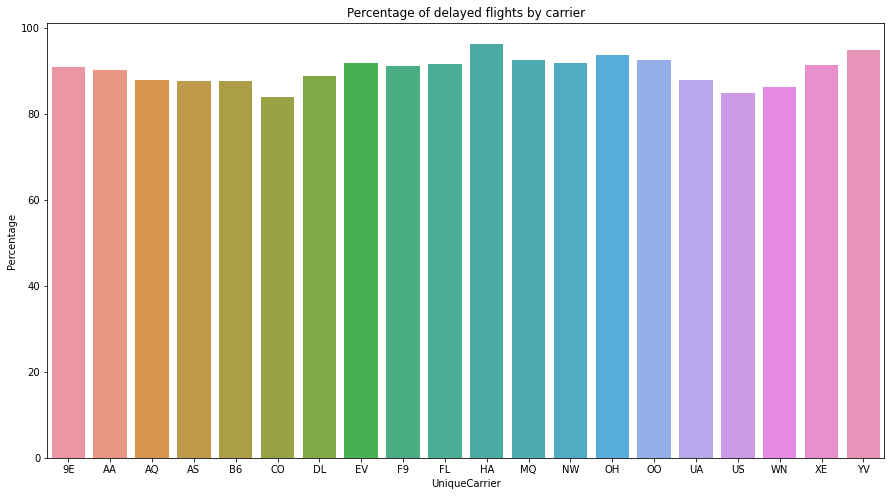

In [16]:

plt.figure(figsize=(15,8))
ax=sns.barplot(x='UniqueCarrier',y='Percentage',data=grouped).set_title('Percentage of delayed flights by carrier')

In the plot we can see, there is no strong variance in the diference of delayed flights  for each carries.Therefore, seems that is not giving important information due to the uniform distribution,so we remove the attribute

In [17]:
df.drop(['UniqueCarrier'],axis=1,inplace=True)


In [18]:
df.drop(['FlightNum'],axis=1,inplace=True)

In [19]:
df.drop([ 'TailNum','Origin', 'Dest','ArrDelay' ], axis=1, inplace=True)

In [20]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,SecurityDelay,680883,64.691286
1,NASDelay,680883,64.691286
2,WeatherDelay,680883,64.691286
3,CarrierDelay,680883,64.691286
4,LateAircraftDelay,680883,64.691286
5,Year,0,100.000000
6,Diverted,0,100.000000
7,Cancelled,0,100.000000
8,TaxiOut,0,100.000000
9,TaxiIn,0,100.000000


In [21]:
df.fillna(0,inplace=True)


### K-Nearest Neighbors 

In [21]:
df_sample=df.sample(500000)

In [22]:
X = df_sample.drop(['Delayed'],axis=1)

In [23]:
y = df_sample['Delayed']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [26]:
start = time.time()
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
end=time.time()
default_knn=exec_time(start,end)
default_knn

Execution Time: 00:23:54


datetime.time(0, 23, 54)

In [27]:
def PrintActualPredicted(act,pred):
    df_print = pd.DataFrame({'Actual':act,'Predicted':pred})
    return(df_print)


In [28]:
PrintActualPredicted(y_test,y_pred)

,Actual,Predicted
1934599,1,1
516946,1,1
1306973,1,1
103326,1,1
170224,1,1
...,...,...
305339,1,1
1854658,1,1
1233230,1,1
31650,1,1


#### Metrics


***Accuracy***

In [29]:
accKnn=metrics.accuracy_score(y_test,y_pred)
print('Classification accuracy is: ',accKnn,'%')

Classification accuracy is:  0.92744 %


***Null accuracy***: accuracy that could be achieved by always predictin the most frequent class 

In [30]:
y_test.value_counts()

1    89395
0    10605
Name: Delayed, dtype: int64

In [31]:
y_test.mean()

0.89395

In [32]:
### percentage of zeros
1-y_test.mean()

0.10604999999999998

In [33]:
max(y_test.mean(),1-y_test.mean())

0.89395

we can check out if our set is unbalanced checking balanced accuracy

this mean that  a dum model that always predict 1 would be rigth 89% of the time  showing that accuracy is not that good as it's close to a dum model  

In [34]:
print(metrics.balanced_accuracy_score(y_test,y_pred))

0.7421695778360686


balanced accuracy gives diferent result meaning that is unbalanced

***Confusion matrix***

In [35]:
confusion= metrics.confusion_matrix(y_test,y_pred)
print(confusion)
TP = confusion[1,1]
TN = confusion[0,0] 
FP = confusion[0,1]
FN = confusion[1,0]

[[ 5377  5228]
 [ 2028 87367]]


***Sensitivity*** When the actual value is positive, how often is the prediction correct?


In [36]:
print(metrics.recall_score(y_test,y_pred))

0.9773141674590301


***Specificity*** When the actual value is negative, how often is the prediction correct?

In [37]:
 specificity = TN / (TN+FP)
print(specificity)

0.507024988213107


our classifier is:
 - Highly sensitive
 - not so specific

***False positive Rate*** 


In [38]:
print(1-specificity)

0.49297501178689296


***F1 Score***

In [39]:
metrics.f1_score(y_test,y_pred)

0.9601296774548053

### Suport vector machine

In [40]:
start = time.time()
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)
end = time.time()
default_svm=exec_time(start,end)

Execution Time: 00:04:57


In [41]:
y_pred = clf.predict(X_test)

### Metrics

***Accuracy***

In [42]:
accSvm=metrics.accuracy_score(y_test,y_pred)
print('Classification accuracy is: ',accSvm*100,'%')

Classification accuracy is:  100.0 %


***Confusion matrix***

In [43]:
confusion_svm = metrics.confusion_matrix(y_test,y_pred)
print(confusion_svm)
TP_svm = confusion_svm[1,1]
TN_svm = confusion_svm[0,0]
FP_svm = confusion_svm[0,1]
FN_svm = confusion_svm[1,0]

[[10605     0]
 [    0 89395]]


***Sensitivity***


In [44]:
print(metrics.recall_score(y_test,y_pred))

1.0


***Specificity***

In [45]:
spec = TN_svm/(TN_svm+FP_svm)
print(spec)

1.0


***Precision***

In [46]:

print(metrics.precision_score(y_test,y_pred))

1.0


***F1 Score***

In [48]:
f1_score_svm= metrics.f1_score(y_test,y_pred)
print(f1_score_svm)

1.0


### XGBoost

In [49]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [50]:
start = time.time()
xgb_class =xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
y_pred=xgb_class.predict(X_test)
end = time.time()
default_xgb=exec_time(start, end)

Execution Time: 00:00:15


In [51]:
PrintActualPredicted(y_test,y_pred)

,Actual,Predicted
1934599,1,1
516946,1,1
1306973,1,1
103326,1,1
170224,1,1
...,...,...
305339,1,1
1854658,1,1
1233230,1,1
31650,1,1


### Metrics

***Accuracy***

In [52]:
accXgb = metrics.accuracy_score(y_test,y_pred)
print(accXgb)

0.99161


***Confusion matrix***

In [53]:
confusion_xgb = metrics.confusion_matrix(y_test,y_pred)
print(confusion_xgb)

[[10009   596]
 [  243 89152]]


In [54]:
TP_xgb = confusion_xgb[1,1]
TN_xgb = confusion_xgb[0,0]
FP_xgb = confusion_xgb[0,1]
FN_xgb = confusion_xgb[1,0]

***Sensitivity***


In [55]:
print(metrics.recall_score(y_test,y_pred))

0.9972817271659489


***Specificity***

In [56]:
spec = TN_xgb/(TN_xgb+FP_xgb)
print(spec)

0.9438000942951438


***Precision***

In [57]:
print(metrics.precision_score(y_test,y_pred))

0.9933591834915542


***F1 Score***

In [58]:
f1_score_xgb = metrics.f1_score(y_test,y_pred)
print(f1_score_xgb)

0.9953165906566261


conclusion:
the best model without threat features is svm with 100% on the metrics.On the other hand KNN is the worst model in terms of metrics and time processing

## Exercici 3

Entrena’ls utilitzant els diferents paràmetres que admeten.

### KNN 

In [22]:
params = {
    'n_neighbors':[1,2,4,6,8,16,32],
    'weights':['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute'],
    'leaf_size':[10,20,40,80],
    'p':[1,2,5]
}

In [23]:
params['n_neighbors']

[1, 2, 4, 6, 8, 16, 32]

In [24]:
df_sample=df.sample(500000)

In [25]:
X=df_sample.drop(['Delayed'],axis=1)

In [26]:
y=df_sample['Delayed']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [65]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (375000, 22) (375000,)
Testing set shape:  (125000, 22) (125000,)


In [66]:
## calculating  the accuracy of models with diferents  neighbors
acc_mean=[]
for i in params['n_neighbors']:
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    yhat= knn.predict(X_test)
    acc_mean.append(metrics.accuracy_score(y_test,yhat))

KeyboardInterrupt: 

In [136]:
acc_mean

[0.923992, 0.90564, 0.919024, 0.921632]

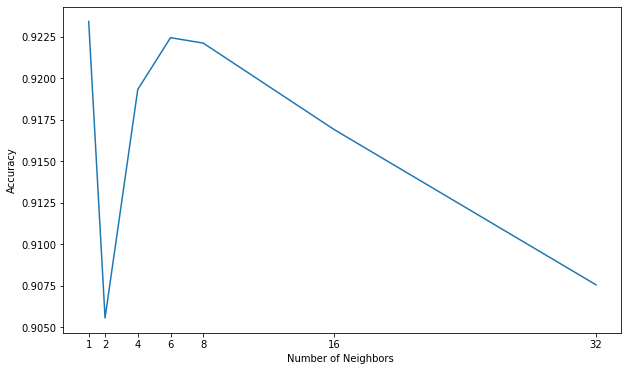

In [79]:

plt.figure(figsize = (10, 6))
plt.plot(params['n_neighbors'], acc_mean)
plt.xticks(params['n_neighbors'])
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [180]:
start=time.time()
clss = KNeighborsClassifier(n_neighbors=6,weights=params['weights'][1],p=params['p'][0],algorithm=params['algorithm'][2])
clss.fit(X_train,y_train)
y_predict=clss.predict(X_test)
end=time.time()
ht_Knn= exec_time(start,end)

Execution Time: 00:00:38


In [181]:
print('Accuracy')
knn_ht_acc=metrics.accuracy_score(y_test,y_predict)
print(knn_ht_acc)
knn_ht_f1=metrics.f1_score(y_test,y_predict)
print('F1 score:\n',knn_ht_f1)
print(metrics.confusion_matrix(y_test,y_predict))

Accuracy
0.929728
F1 score:
 0.9612339467761154
[[  7313   6082]
 [  2702 108903]]


the metrics are better than default mode

### SVM

In [69]:
kernels = ['Polynomial', 'Sigmoid','Linear']
def getClassifier(kernel):
    
    if kernel=='Polynomial':
        return svm.SVC(kernel='poly',degree=5,gamma='auto')
   
    elif kernel == 'Sigmoid':
        return svm.SVC(kernel='sigmoid',gamma='auto')
    elif kernel == 'Linear':
        return svm.SVC(kernel='linear',gamma='auto')

In [70]:
acc =[]
time_svm =[]
for i in kernels:
    start = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
    svcclassifier = getClassifier(i)
    print('fitting the model')
    svcclassifier.fit(X_train,y_train)
    print('predicting new values')
    y_pred=svcclassifier.predict(X_test)
    end = time.time()
    ht_svm=exec_time(start,end)
    time_svm.append(ht_svm)
    print('Evaluation of',i,'kernel') 
    acc.append(metrics.accuracy_score(y_test,y_pred))
    print(metrics.classification_report(y_test,y_pred))

fitting the model
predicting new values
Execution Time: 00:08:02
Evaluation of Polynomial kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10552
           1       1.00      1.00      1.00     89448

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

fitting the model
predicting new values
Execution Time: 00:27:29
Evaluation of Sigmoid kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10672
           1       0.89      1.00      0.94     89328

    accuracy                           0.89    100000
   macro avg       0.45      0.50      0.47    100000
weighted avg       0.80      0.89      0.84    100000



C:\Users\adria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\adria\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fitting the model
predicting new values
Execution Time: 00:02:21
Evaluation of Linear kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10704
           1       1.00      1.00      1.00     89296

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000



 as we can see exept rbf kernel wich i did not compute due the extense comupting time , the other kernels  gives good results

### XGBoost

In [72]:
df_sample=df.sample(500000)

X = df_sample.drop(['Delayed'],axis=1)

y = df_sample['Delayed']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [74]:
xgbparams={
    'max_depth':[2,4,8,16,30],
    'subsample':[0.2,0.4,0.8,1],
    'n_estimators':[10,20,40,60,80],
    'learning_rate':[0.2,0.4,0.8,1]
}

In [27]:
train_acc=[]
test_acc=[]

model=xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
model.fit(X_train,y_train)

y_predict=model.predict(X_test)
y_train_predict=model.predict(X_train)
print('Training accuracy',metrics.accuracy_score(y_train,y_train_predict))
print('Test accuracy',metrics.accuracy_score(y_test,y_predict))

Training accuracy 0.995695
Test accuracy 0.9919


In [77]:
acc_ht_xgb=[]
for k,v in xgbparams.items():
    start = time.time()
    if k=='max_depth':
        max_depth_train_acc=[]
        max_depth_test_acc=[]
        for value in v:
            print(k,value)
            model=xgb.XGBClassifier(max_depth=value,eval_metric='mlogloss',use_label_encoder =False)
            model.fit(X_train,y_train)
            y_predict=model.predict(X_test)
            y_train_predict=model.predict(X_train)
            train_ac=metrics.accuracy_score(y_train,y_train_predict)
            test_ac=metrics.accuracy_score(y_test,y_predict)
            print('Training accuracy',train_ac)
            max_depth_train_acc.append(train_ac)
            print('test accuracy',test_ac)
            max_depth_test_acc.append(test_ac)
            
    elif k=='subsample':
        subsample_train_acc=[]
        subsample_test_acc=[]
        for value in v:
            print(k,value)
            model=xgb.XGBClassifier(subsample=value,eval_metric='mlogloss',use_label_encoder =False)
            model.fit(X_train,y_train)
            y_predict=model.predict(X_test)
            y_train_predict=model.predict(X_train)
            train_ac=metrics.accuracy_score(y_train,y_train_predict)
            test_ac=metrics.accuracy_score(y_test,y_predict)
            print('Training accuracy',train_ac)
            subsample_train_acc.append(train_ac)
            print('test accuracy',test_ac)
            subsample_test_acc.append(test_ac)
    elif k == 'n_estimators':
        n_estimators_train_acc=[]
        n_estimators_test_acc=[]
        for value in v:
            print(k,value)
            model=xgb.XGBClassifier(n_estimators=value,eval_metric='mlogloss',use_label_encoder =False)
            model.fit(X_train,y_train)
            y_predict=model.predict(X_test)
            y_train_predict=model.predict(X_train)
            train_ac=metrics.accuracy_score(y_train,y_train_predict)
            test_ac=metrics.accuracy_score(y_test,y_predict)
            print('Training accuracy',train_ac)
            n_estimators_train_acc.append(train_ac)
            print('test accuracy',test_ac)
            n_estimators_test_acc.append(test_ac)
    elif k == 'learning_rate':
        learning_train_acc=[]
        learning_test_acc=[]
        for value in v:
            print(k,value)
            model=xgb.XGBClassifier(learning_rate=value,eval_metric='mlogloss',use_label_encoder =False)
            model.fit(X_train,y_train)
            y_predict=model.predict(X_test)
            y_train_predict=model.predict(X_train)
            train_ac=metrics.accuracy_score(y_train,y_train_predict)
            test_ac=metrics.accuracy_score(y_test,y_predict)
            print('Training accuracy',train_ac)
            learning_train_acc.append(train_ac)
            print('test accuracy',test_ac)
            learning_test_acc.append(test_ac)
    end = time.time()
    ht_xgb=exec_time(start,end)
    acc_ht_xgb.append(ht_xgb)
            

max_depth 2
Training accuracy 0.9492825
test accuracy 0.94946
max_depth 4
Training accuracy 0.98478
test accuracy 0.9823
max_depth 8
Training accuracy 0.99921
test accuracy 0.99389
max_depth 16
Training accuracy 1.0
test accuracy 0.99495
max_depth 30
Training accuracy 1.0
test accuracy 0.99487
Execution Time: 00:01:44
subsample 0.2
Training accuracy 0.9922125
test accuracy 0.98898
subsample 0.4
Training accuracy 0.99427
test accuracy 0.99093
subsample 0.8
Training accuracy 0.99527
test accuracy 0.99138
subsample 1
Training accuracy 0.9956125
test accuracy 0.99117
Execution Time: 00:00:49
n_estimators 10
Training accuracy 0.9339
test accuracy 0.9336
n_estimators 20
Training accuracy 0.9446625
test accuracy 0.94333
n_estimators 40
Training accuracy 0.9804975
test accuracy 0.97719
n_estimators 60
Training accuracy 0.9901075
test accuracy 0.98642
n_estimators 80
Training accuracy 0.9938775
test accuracy 0.9897
Execution Time: 00:00:22
learning_rate 0.2
Training accuracy 0.99234
test accura

In [62]:

def xgbplot(k,train,test):
        plt.figure(figsize = (10, 6))
        plt.plot(xgbparams[k],train,label='Train accuracy')
        plt.plot(xgbparams[k],test,label='test accuracy')
        plt.xticks(xgbparams[k])
        plt.xlabel('Number of {}'.format(k))
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

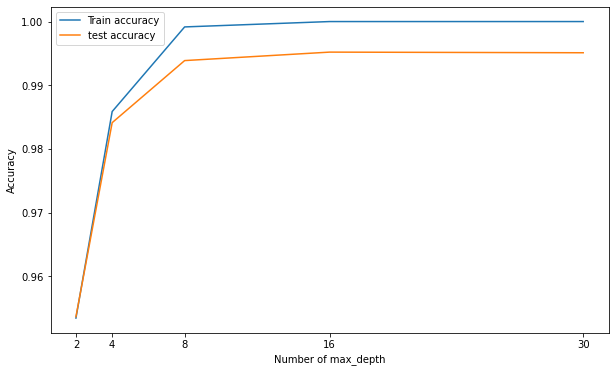

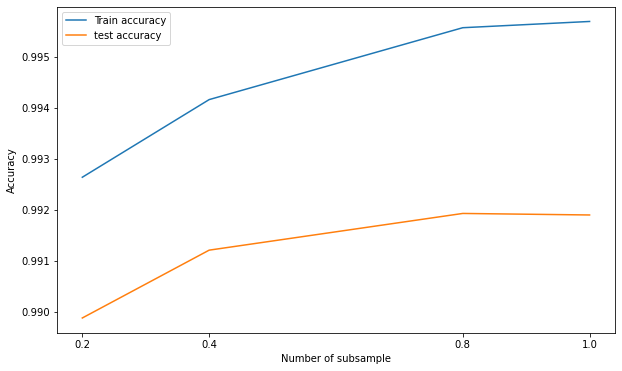

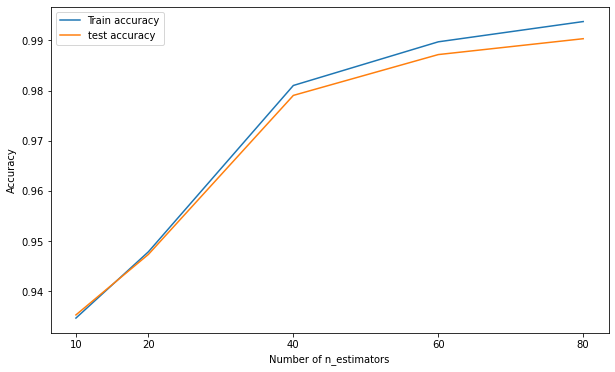

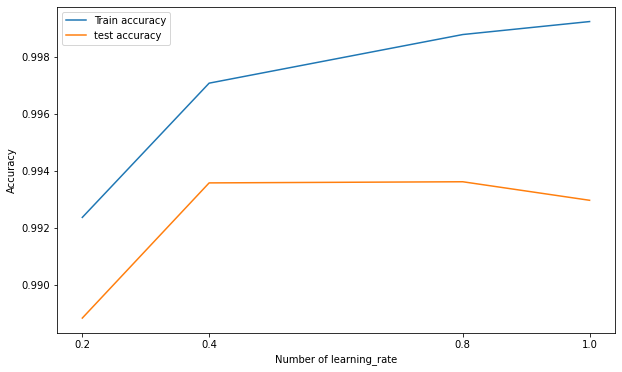

In [63]:
for k,v in xgbparams.items():
    if k =='max_depth':
        xgbplot(k,max_depth_train_acc,max_depth_test_acc)
    elif k =='subsample':
        xgbplot(k,subsample_train_acc,subsample_test_acc)
    elif k =='n_estimators':
        xgbplot(k,n_estimators_train_acc,n_estimators_test_acc)
    elif k =='learning_rate':
        xgbplot(k,learning_train_acc,learning_test_acc)
    

In [163]:
start = time.time()
xgb_class =xgb.XGBClassifier(max_depth=8,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
xgb_class.fit(X_train,y_train)
yxgb_pred=xgb_class.predict(X_test)
end = time.time()
ht_time_xgb = exec_time(start,end)
ht_xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',ht_xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

Execution Time: 00:00:13
accuracy 0.99362
confusion matrix
 [[10202   414]
 [  224 89160]]
f1 score 0.9964349176901843


## Exercici 4 
Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation

In [83]:
df_sample=df.sample(500000)

In [84]:
X=df_sample.drop(['Delayed'],axis=1)

In [85]:
y=df_sample['Delayed']

***KNN cross validation***

In [89]:

start = time.time()
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn,X,y,cv=5)
end = time.time()
knn_crossval_time = exec_time(start,end)
knn_crossval_time 

Execution Time: 01:13:53


datetime.time(1, 13, 53)

In [90]:
 scores.mean()

0.9262119999999999

***SVM cross validation***

In [92]:

start=time.time()
clsvm = svm.SVC(kernel='linear')
score_svm =cross_val_score(clsvm,X,y,cv=5)
end = time.time()
svm_cross_val_time = exec_time(start,end)


Execution Time: 00:07:34


In [93]:
score_svm.mean()

1.0

***XGBoost cross validation***

In [94]:

start = time.time()
xgbCls=xgb.XGBClassifier(eval_metric='mlogloss',use_label_encoder =False)
score_xgb=cross_val_score(xgbCls,X,y,cv=5)
end = time.time()
xgb_crossval_time = exec_time(start,end)

Execution Time: 00:00:45


In [95]:
score_xgb.mean()

0.9918099999999999

In [96]:
cvdf= pd.DataFrame({'KNN':scores.mean(),'SVM':score_svm.mean(),'Xgboost':score_xgb.mean()},index=['cross val accuracy mean'])

In [231]:
cvdf1= pd.DataFrame({'KNN':scores,'SVM':score_svm,'Xgboost':score_xgb})


In [233]:
cvdf

,KNN,SVM,Xgboost
cross val accuracy mean,0.926212,1.0,0.99181


In [98]:
accKnn,accSvm,accXgb

(0.92744, 1.0, 0.99161)

In [99]:
tt_acc = pd.Series(data={'KNN':accKnn,'SVM':accSvm,'Xgboost':accXgb},name='train test accuracy')

In [100]:
cvdf.append(tt_acc,ignore_index=False)

,KNN,SVM,Xgboost
cross val accuracy mean,0.926212,1.0,0.99181
train test accuracy,0.927440,1.0,0.99161


the results show no significant variance between cross validation and train test perfomance

### Nivell 2
#### Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

We will try to optimize the performance of KNN and Xgboost, we will not use SVM because it have 100% of correct predictions 

In [101]:
df_sample=df.sample(500000)

X = df_sample.drop(['Delayed'],axis=1)

y = df_sample['Delayed']

In [102]:
corr_matrix = X.corr()

<AxesSubplot:>

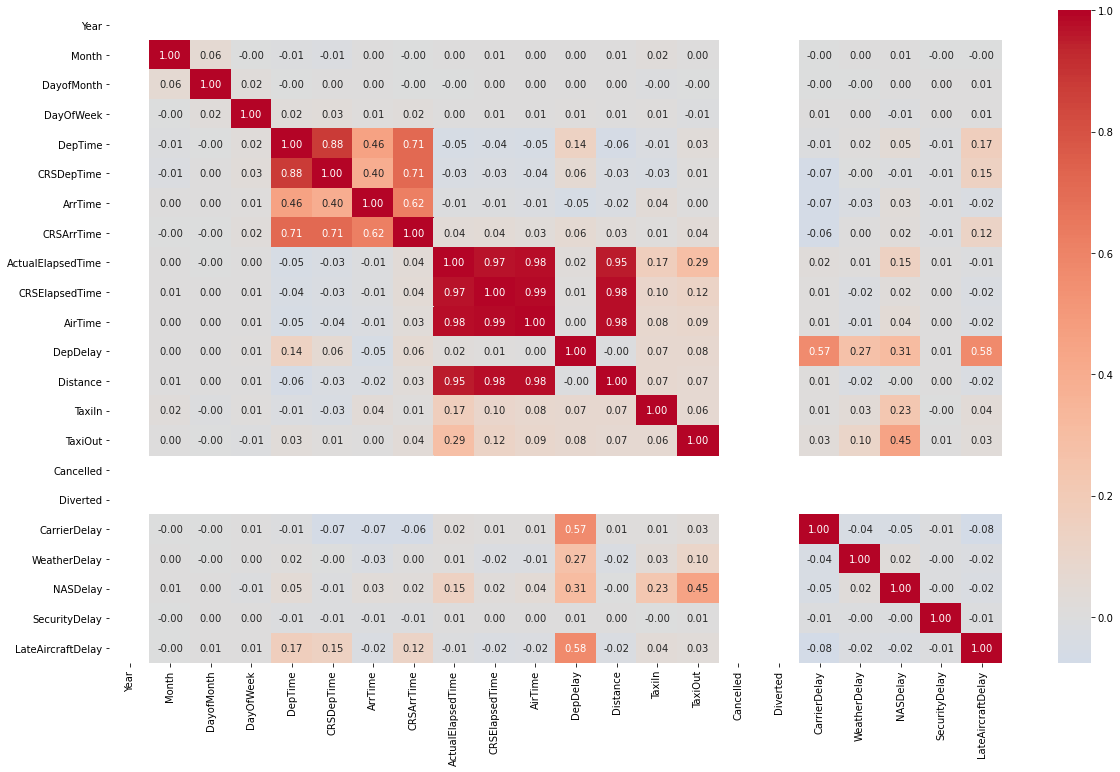

In [103]:
plt.figure(figsize=(20,12))


sns.heatmap(corr_matrix, center=0, annot=True, 
                fmt='.2f', cmap='coolwarm')

***Min Max Scaler***

In [29]:
scaler = MinMaxScaler()

In [27]:
Xs=scaler.fit_transform(X)

In [106]:
X_train,X_test,y_train,y_test =train_test_split(Xs,y, random_state=0)

***KNN***

In [133]:
clss = KNeighborsClassifier(n_neighbors=8,weights=params['weights'][1],p=params['p'][0],algorithm=params['algorithm'][2],n_jobs=-1)

In [134]:
clsKnn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=8, p=1)

In [135]:
yKnn_pred=clsKnn.predict(X_test)

In [136]:
knn_acc =metrics.accuracy_score(y_test,yKnn_pred)
knn_confusion = metrics.confusion_matrix(y_test,yKnn_pred)
knn_f1_score = metrics.f1_score(y_test,yKnn_pred)
print('accuracy',knn_acc)
print('confusion matrix\n', knn_confusion)
print('f1 score',knn_f1_score)

accuracy 0.884232
confusion matrix
 [[  1960  11336]
 [  3135 108569]]
f1 score 0.9375196991481334


through min max scaler we improve the metrics of knn

***XGboost***

In [164]:
xgb_class =xgb.XGBClassifier(max_depth=8,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)

In [165]:
xgb_class.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [166]:
yxgb_pred=xgb_class.predict(X_test)

In [160]:
xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.993616
confusion matrix
 [[ 12629    504]
 [   294 111573]]
f1 score 0.996436609152288


in this case  doing min max scaler  the metrics of XGboos are worst we will try diferent scale method

In [107]:
Sd_scale = StandardScaler()

In [108]:
Xsd=Sd_scale.fit_transform(X)

In [274]:
X_train,X_test,y_train,y_test =train_test_split(Xsd,y, random_state=0)

In [275]:
xgb_class =xgb.XGBClassifier(max_depth=8,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)

In [276]:
xgb_class.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=12,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [277]:
yxgb_pred=xgb_class.predict(X_test)

In [278]:
xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.99324
confusion matrix
 [[ 12652    558]
 [   287 111503]]
f1 score 0.9962251676338278


the metrics still are worst in comparison to metrics without feature engineering.We will try to improve them with feature selection


In [191]:
clf = RFC( random_state=0)
clf.fit(X, y)


RandomForestClassifier(random_state=0)

In [192]:
yrf_predict=clf.predict(X_test)

In [193]:
rf_acc =metrics.accuracy_score(y_test,yrf_predict)
xgb_confusion = metrics.confusion_matrix(y_test,yrf_predict)
xgb_f1_score = metrics.f1_score(y_test,yrf_predict)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.99343
confusion matrix
 [[ 8879  1767]
 [  360 88994]]
f1 score 0.9881908780501347


In [194]:
importance =clf.feature_importances_

In [195]:
importance

array([0.00000000e+00, 2.29333864e-02, 2.97592252e-02, 1.79898673e-02,
       3.46686893e-02, 3.18708652e-02, 3.90943462e-02, 3.78891333e-02,
       1.14007945e-01, 1.62320620e-01, 6.91182840e-02, 1.77837051e-01,
       5.70188126e-02, 2.76190077e-02, 5.04690165e-02, 0.00000000e+00,
       0.00000000e+00, 4.34229801e-02, 3.35862040e-03, 4.51106031e-02,
       9.90473369e-05, 3.54124995e-02])

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.02293
Feature: 2, Score: 0.02976
Feature: 3, Score: 0.01799
Feature: 4, Score: 0.03467
Feature: 5, Score: 0.03187
Feature: 6, Score: 0.03909
Feature: 7, Score: 0.03789
Feature: 8, Score: 0.11401
Feature: 9, Score: 0.16232
Feature: 10, Score: 0.06912
Feature: 11, Score: 0.17784
Feature: 12, Score: 0.05702
Feature: 13, Score: 0.02762
Feature: 14, Score: 0.05047
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.04342
Feature: 18, Score: 0.00336
Feature: 19, Score: 0.04511
Feature: 20, Score: 0.00010
Feature: 21, Score: 0.03541


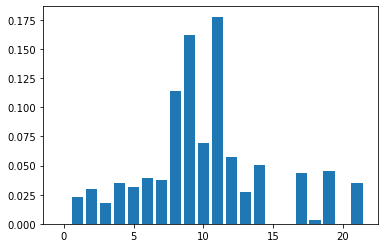

In [197]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [165]:
Xxgb=X.iloc[:,[8,9,11]]
scaler = MinMaxScaler()

Xs=scaler.fit_transform(Xxgb)


In [166]:
X_train,X_test,y_train,y_test =train_test_split(Xs,y, random_state=0)

In [167]:
start = time.time()
xgb_class =xgb.XGBClassifier(max_depth=8,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
yxgb_pred=xgb_class.predict(X_test)
end = time.time()
FE_xgb_time = exec_time(start,end)

Execution Time: 00:00:09


In [168]:
xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.99584
confusion matrix
 [[ 12926    330]
 [   190 111554]]
f1 score 0.9976747097858943


In [169]:
Xsd=Sd_scale.fit_transform(Xxgb)

In [170]:
X_train,X_test,y_train,y_test =train_test_split(Xsd,y, random_state=0)

In [171]:
start = time.time()
xgb_class =xgb.XGBClassifier(max_depth=8,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
yxgb_pred=xgb_class.predict(X_test)
end = time.time()
FE_xgb_time = exec_time(start,end)

Execution Time: 00:00:09


In [172]:
xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.99584
confusion matrix
 [[ 12922    334]
 [   186 111558]]
f1 score 0.9976747929671429


with the feature selection and min max scaler we improve significantly the metrics , we will do the same with KNN 


In [27]:
XKnn=X.iloc[:,[8,9,11]]

In [30]:
Xs=scaler.fit_transform(XKnn)

In [122]:
X_train,X_test,y_train,y_test =train_test_split(XKnn,y, random_state=0)

In [123]:
start = time.time()
clsKnn = KNeighborsClassifier(n_neighbors=8,weights=params['weights'][1],p=params['p'][0],algorithm=params['algorithm'][2],n_jobs=-1)
clsKnn.fit(X_train,y_train)
yKnn_pred=clsKnn.predict(X_test)
end = time.time()
FE_Knn_time= exec_time(start,end)

Execution Time: 00:00:02


In [124]:
knn_acc =metrics.accuracy_score(y_test,yKnn_pred)
knn_confusion = metrics.confusion_matrix(y_test,yKnn_pred)
knn_f1_score = metrics.f1_score(y_test,yKnn_pred)
print('accuracy',knn_acc)
print('confusion matrix\n', knn_confusion)
print('f1 score',knn_f1_score)

accuracy 0.996624
confusion matrix
 [[ 13022    234]
 [   188 111556]]
f1 score 0.998112144013886


In [125]:
Xsd=Sd_scale.fit_transform(XKnn)

X_train,X_test,y_train,y_test =train_test_split(Xsd,y, random_state=0)

In [126]:
clss = KNeighborsClassifier(n_neighbors=8,weights=params['weights'][1],p=params['p'][0],algorithm=params['algorithm'][2],n_jobs=-1)

In [127]:
clsKnn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=8, p=1,
                     weights='distance')

In [128]:
yKnn_pred=clsKnn.predict(X_test)

In [129]:
knn_acc =metrics.accuracy_score(y_test,yKnn_pred)
knn_confusion = metrics.confusion_matrix(y_test,yKnn_pred)
knn_f1_score = metrics.f1_score(y_test,yKnn_pred)
print('accuracy',knn_acc)
print('confusion matrix\n', knn_confusion)
print('f1 score',knn_f1_score)

accuracy 0.996464
confusion matrix
 [[ 12965    291]
 [   151 111593]]
f1 score 0.9980235033180103


we can see that with feature selection of 'ActualElapsedTime', 'CRSElapsedTime', 'DepDelay'  and min Max scale we get much better metrics  and the process time decrease notoriously

finally we will try the same configuration with SVM in order to see if we can decrease the time processing

In [39]:
Xsvm=X.iloc[:,[8,9,11]]



X_train,X_test,y_train,y_test =train_test_split(Xsvm,y, random_state=0)

In [40]:
start = time.time()
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)
ysvm_pred = clf.predict(X_test)
end = time.time()
Fe_svm_time= exec_time(start,end)

Execution Time: 00:00:02


In [41]:
ysvm_acc =metrics.accuracy_score(y_test,ysvm_pred)
ysvm_confusion = metrics.confusion_matrix(y_test,ysvm_pred)
ysvm_f1_score = metrics.f1_score(y_test,ysvm_pred)
print('accuracy',ysvm_acc)
print('confusion matrix\n', ysvm_confusion)
print('f1 score',ysvm_f1_score)

accuracy 1.0
confusion matrix
 [[ 13289      0]
 [     0 111711]]
f1 score 1.0


we get the best results almost immediately proving that we get the best combination

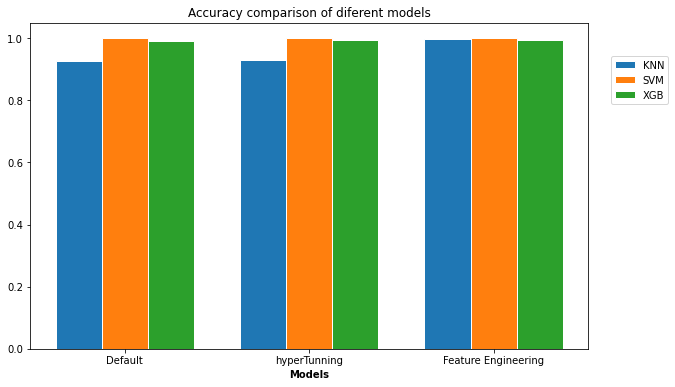

In [162]:
barWidth = 0.25
plt.figure(figsize=(10,6))
bar1=[accKnn,knn_ht_acc,knn_acc]
bar2= [accSvm,acc[2],ysvm_acc]
bar3= [accXgb,ht_xgb_acc,xgb_acc]

r1 = np.arange(len(bar1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, bar1, width=barWidth, edgecolor='white', label='KNN')
plt.bar(r2, bar2, width=barWidth, edgecolor='white', label='SVM')
plt.bar(r3, bar3, width=barWidth, edgecolor='white', label='XGB')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bar1))], ['Default', 'hyperTunning', 'Feature Engineering'])
plt.legend(loc=(1.04,0.75))
plt.title('Accuracy comparison of diferent models')
plt.show()

In [227]:
bar1=[default_knn,ht_Knn,FE_Knn_time]
bar2= [default_svm,time_svm[2],Fe_svm_time]
bar3= [default_xgb,ht_time_xgb,FE_xgb_time ]

time_knn = []
time_svm = []
time_xgb = []
for x in bar1:
    seconds = x.minute *60
    total_seconds=x.second +seconds
    time_knn.append(total_seconds)

for x in bar2:
    seconds = x.minute *60
    total_seconds=x.second +seconds
    time_svm.append(total_seconds)

for x in bar3:
    seconds = x.minute *60
    total_seconds=x.second +seconds
    time_xgb.append(total_seconds)


1434
38
2
297
141
2
15
13
9
[1434, 38, 2]
[297, 141, 2]
[15, 13, 9]


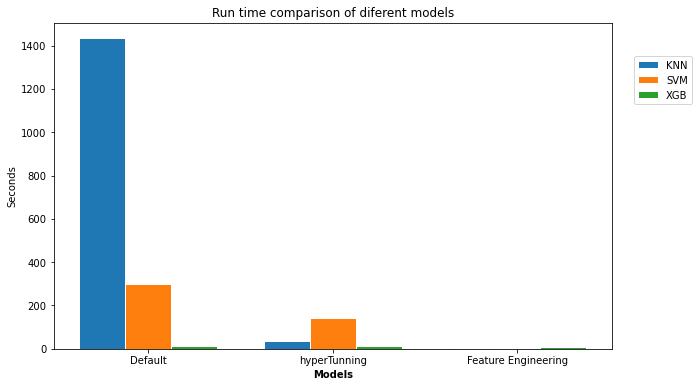

In [229]:
barWidth = 0.25
plt.figure(figsize=(10,6))

r1 = np.arange(len(time_knn))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, time_knn, width=barWidth, edgecolor='white', label='KNN')
plt.bar(r2, time_svm, width=barWidth, edgecolor='white', label='SVM')
plt.bar(r3, time_xgb, width=barWidth, edgecolor='white', label='XGB')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Seconds')
plt.xticks([r + barWidth for r in range(len(bar1))], ['Default', 'hyperTunning', 'Feature Engineering'])
plt.legend(loc=(1.04,0.75))
plt.title('Run time comparison of diferent models')
plt.show()

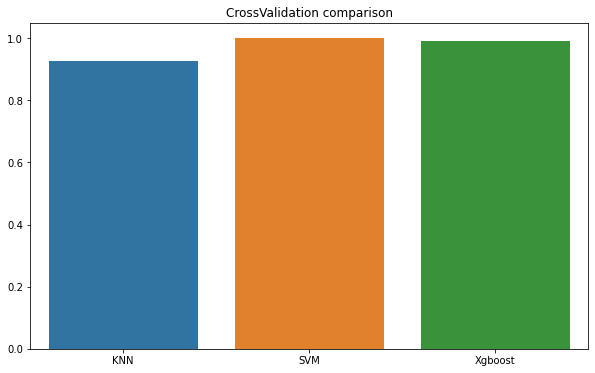

In [248]:
plt.figure(figsize=(10,6))
sns.barplot(data=cvdf1)
plt.title('CrossValidation comparison')
plt.show()

## Nivell 3
### Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

In [50]:
X6 =X.iloc[:,[8,9,10]]

In [51]:
Xs=scaler.fit_transform(X6)

***KNN***

In [45]:
X_train,X_test,y_train,y_test =train_test_split(Xs,y, random_state=0)

In [46]:
start = time.time()
clsKnn = KNeighborsClassifier(n_neighbors=6,weights=params['weights'][1],p=params['p'][0],algorithm=params['algorithm'][2],n_jobs=-1)
clsKnn.fit(X_train,y_train)
yKnn_pred=clsKnn.predict(X_test)
end = time.time()
FE_Knn_time= exec_time(start,end)

Execution Time: 00:00:01


In [47]:
knn_acc =metrics.accuracy_score(y_test,yKnn_pred)
knn_confusion = metrics.confusion_matrix(y_test,yKnn_pred)
knn_f1_score = metrics.f1_score(y_test,yKnn_pred)
print('accuracy',knn_acc)
print('confusion matrix\n', knn_confusion)
print('f1 score',knn_f1_score)

accuracy 0.866672
confusion matrix
 [[  3965   9324]
 [  7342 104369]]
f1 score 0.9260616493052476


***SVM***


In [48]:
X_train,X_test,y_train,y_test =train_test_split(X6,y, random_state=0)
start = time.time()
clf = svm.SVC(kernel='linear')
clf.fit(X_train,y_train)
ysvm_pred = clf.predict(X_test)
end = time.time()
Fe_svm_time= exec_time(start,end)

Execution Time: 00:47:16


In [49]:
ysvm_acc =metrics.accuracy_score(y_test,ysvm_pred)
ysvm_confusion = metrics.confusion_matrix(y_test,ysvm_pred)
ysvm_f1_score = metrics.f1_score(y_test,ysvm_pred)
print('accuracy',ysvm_acc)
print('confusion matrix\n', ysvm_confusion)
print('f1 score',ysvm_f1_score)

accuracy 0.893688
confusion matrix
 [[     0  13289]
 [     0 111711]]
f1 score 0.943859812176029


***XGB***

In [53]:
start = time.time()
X_train,X_test,y_train,y_test =train_test_split(Xs,y, random_state=0)
xgb_class =xgb.XGBClassifier(max_depth=6,subsample=0.8,n_estimators=80,learning_rate=0.4,eval_metric='mlogloss',use_label_encoder =False)
xgb_class.fit(X_train,y_train)
yxgb_pred=xgb_class.predict(X_test)
end = time.time()
FE_xgb_time = exec_time(start,end)

Execution Time: 00:00:07


In [54]:
xgb_acc =metrics.accuracy_score(y_test,yxgb_pred)
xgb_confusion = metrics.confusion_matrix(y_test,yxgb_pred)
xgb_f1_score = metrics.f1_score(y_test,yxgb_pred)
print('accuracy',xgb_acc)
print('confusion matrix\n', xgb_confusion)
print('f1 score',xgb_f1_score)

accuracy 0.894144
confusion matrix
 [[  1287  12002]
 [  1230 110481]]
f1 score 0.9434998334713955


As we can see the metrics  without DepDelay are quite bad, specially  for  SVM model which it spend 47 minutes in run time . Meaning that DepDelay is esencial for the explanation of the Target  variance